<a href="https://colab.research.google.com/github/ProstoRav/Netology/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%C2%AB%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_ARMA%C2%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Импорт библиотек
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

from itertools import product
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import statsmodels.tsa.api as smt

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive/')

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

Mounted at /content/drive/


In [2]:
# Загрузка данных и приведение к временному индексу
sales = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Netology/4. Временные ряды/Лекция_tsml + ДЗ/Series/monthly-sales-of-company-x-jan-6.csv')

sales["Month"] = pd.to_datetime(sales["Month"])
sales = sales.set_index("Month").asfreq("MS")
y = sales["Count"].astype(float)

In [3]:
# RMSE
def rmse(y_true, y_pred):
    return float(root_mean_squared_error(np.asarray(y_true), np.asarray(y_pred)))

# Тест Дики–Фуллера
def test_stationarity(timeseries: pd.Series):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries.dropna(), autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"]
    )
    for key, value in dftest[4].items():
        dfoutput[f"Critical Value ({key})"] = value
    print(dfoutput)

# Визуализация графиков
def tsplot(y, title, lags=None, figsize=(16, 8), style="bmh"):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax  = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax= plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, label="Series")
        ts_ax.set_title(title)
        ts_ax.legend(loc="upper left")

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, method="ywm")
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

## Анализ ряда

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


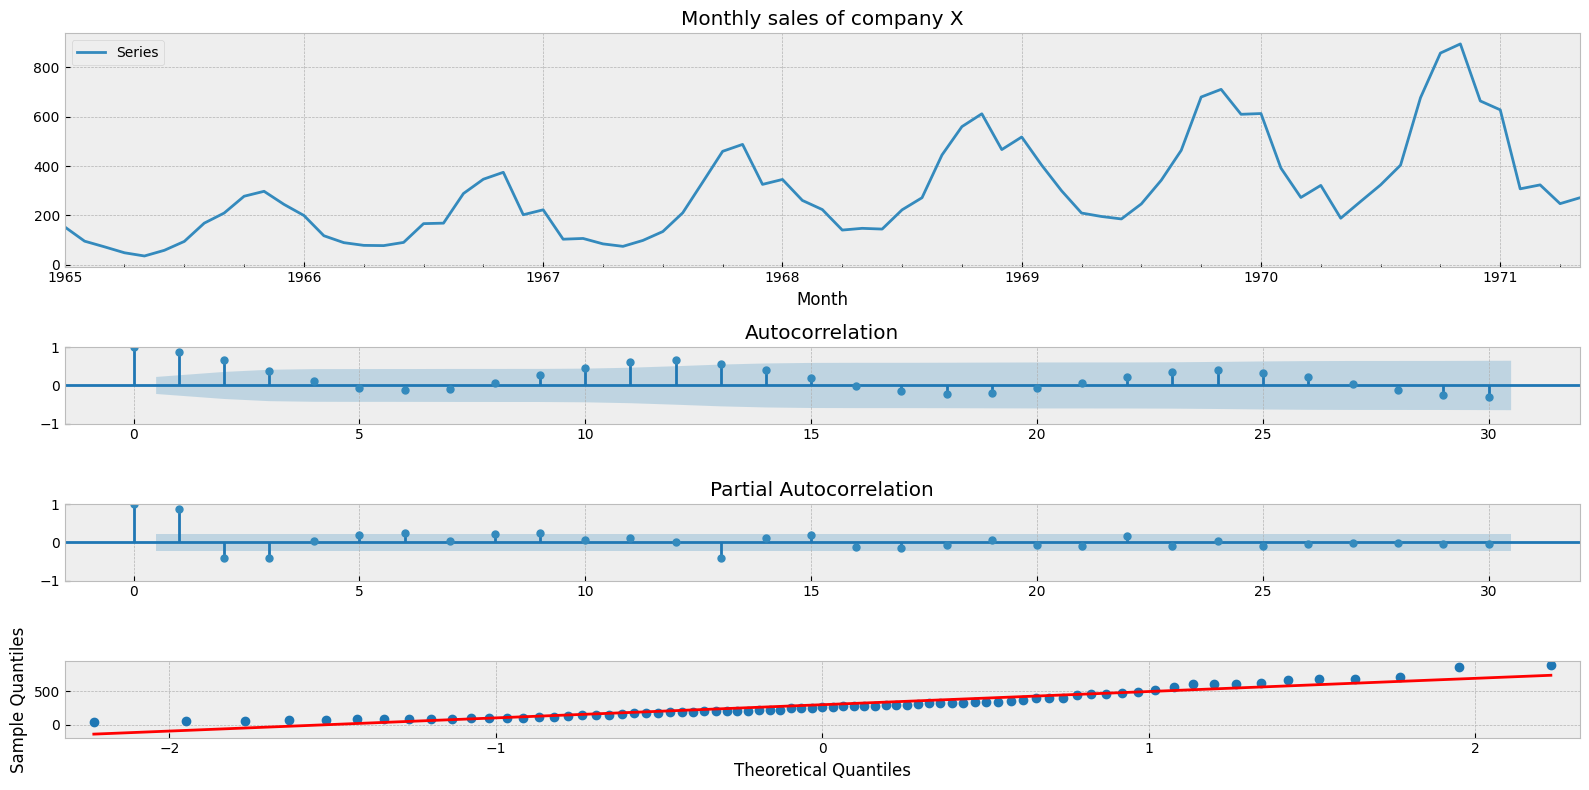

In [4]:
tsplot(y, "Monthly sales of company X", lags=30)

- По тесту Дики–Фуллера ряд выглядит нестационарным.  
- Есть сезонные пики с периодом около 12 месяцев, поэтому далее берём модель SARIMA (ARIMA + сезонность).

## Схема подбора параметров и оценка качества

1. Откладываем конец ряда (12 месяцев) под тест.
2. Оставшуюся часть берём на train и подбираем параметры модели по AIC.
3. Фиксируем лучшую модель и строим прогноз на тесте.


In [5]:
# Разбиение временного ряда
test_size = 12
train = y.iloc[:-test_size]
test  = y.iloc[-test_size:]

train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('1965-01-01 00:00:00'),
 Timestamp('1970-05-01 00:00:00'),
 Timestamp('1970-06-01 00:00:00'),
 Timestamp('1971-05-01 00:00:00'))

## Подбор параметров SARIMA по AIC

In [6]:
# progress bar
try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = None

# Быстрый grid search для SARIMA(SARIMAX) по AIC:
def sarima_grid_search_fast(
    y_train: pd.Series,
    p_range=range(0, 3),
    d_range=range(0, 2),
    q_range=range(0, 3),
    P_range=range(0, 2),
    D_range=range(0, 2),
    Q_range=range(0, 2),
    m=12,
    trend="c",
    maxiter=30,
    method="lbfgs",
    early_stop_rounds=250,
    min_improve=1e-3,
    n_jobs=-1,
    verbose=True,
):
    y_train = pd.Series(y_train).astype(float)

    combos = list(product(p_range, d_range, q_range, P_range, D_range, Q_range))
    iterator = combos
    if verbose and tqdm is not None:
        iterator = tqdm(combos, total=len(combos), desc="SARIMA grid", leave=False)

    best_aic = np.inf
    best_cfg = None
    best_res = None

    # для early stopping
    since_best = 0

    rows = []

    def fit_one(cfg):
        p, d, q, P, D, Q = cfg
        try:
            mdl = SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                trend=trend,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            res = mdl.fit(disp=False, method=method, maxiter=maxiter)
            return (cfg, float(res.aic), res)
        except Exception:
            return (cfg, np.inf, None)

    for cfg in iterator:
        cfg, aic, res = fit_one(cfg)
        p, d, q, P, D, Q = cfg
        rows.append({"order": (p, d, q), "seasonal_order": (P, D, Q, m), "aic": aic})

        if aic + min_improve < best_aic:
            best_aic = aic
            best_cfg = {"order": (p, d, q), "seasonal_order": (P, D, Q, m)}
            best_res = res
            since_best = 0
        else:
            since_best += 1

        if early_stop_rounds is not None and since_best >= early_stop_rounds:
            if verbose:
                print(f"Early stop: нет улучшений {early_stop_rounds} комбинаций подряд.")
            break

    results_df = pd.DataFrame(rows).sort_values("aic").reset_index(drop=True)
    return best_aic, best_cfg, best_res, results_df

best_aic, best_cfg, best_res, results = sarima_grid_search_fast(
    train,
    p_range=range(0, 3), d_range=range(0, 2), q_range=range(0, 3),
    P_range=range(0, 2), D_range=range(0, 2), Q_range=range(0, 2),
    m=12,
    trend="c",
    maxiter=30,
    early_stop_rounds=200,
    verbose=True
)

SARIMA grid:   0%|          | 0/144 [00:00<?, ?it/s]

In [7]:
best_aic

401.7307295472302

In [8]:
best_cfg

{'order': (2, 1, 2), 'seasonal_order': (0, 1, 1, 12)}

## Обучение лучшей модели и прогноз на тесте

In [9]:
# Переобучение лучшей конфигурации на train и прогнозирование
best_model = SARIMAX(
    train,
    order=best_cfg["order"],
    seasonal_order=best_cfg["seasonal_order"],
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

forecast_res = best_model.get_forecast(steps=len(test))
fc = forecast_res.predicted_mean
ci = forecast_res.conf_int()

score = rmse(test.values, fc.values)
score

94.15631219460188

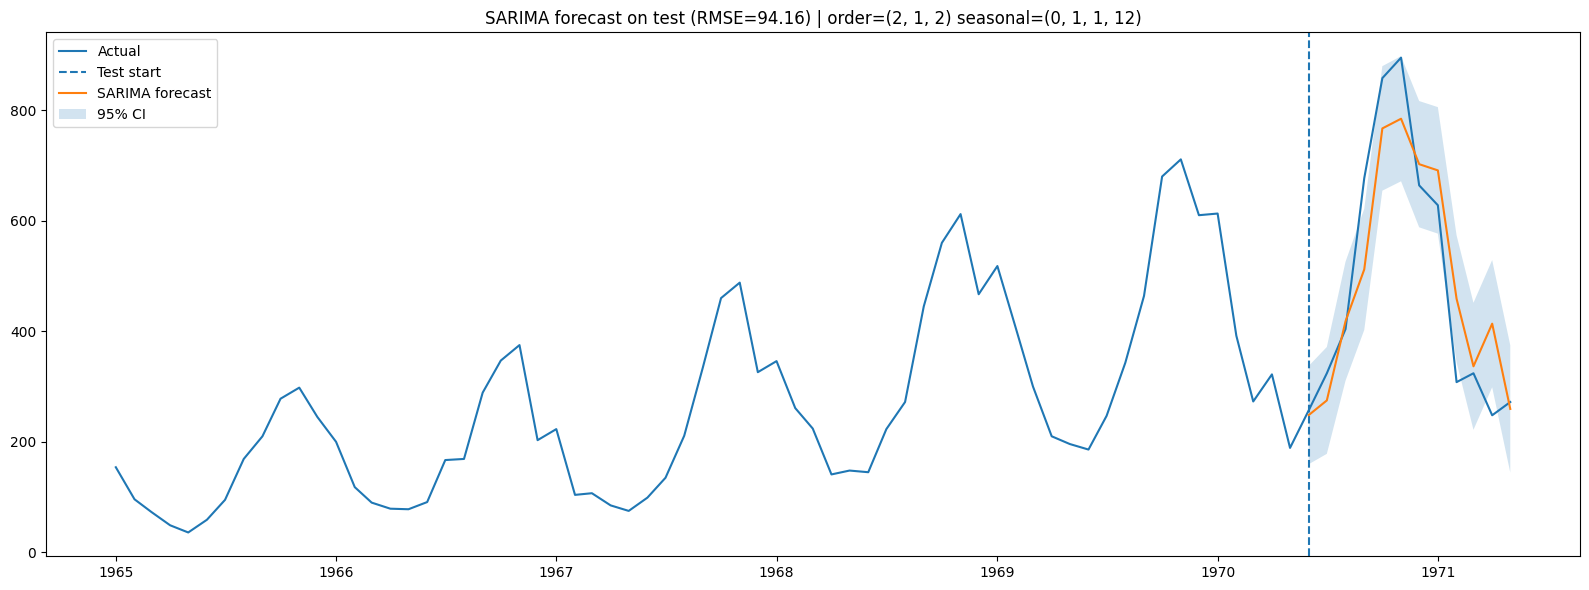

In [10]:
# Визуализация прогноза
plt.figure(figsize=(16,6))
plt.plot(y.index, y.values, label="Actual")
plt.axvline(test.index[0], linestyle="--", label="Test start")
plt.plot(test.index, fc.values, label="SARIMA forecast")

plt.fill_between(test.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2, label="95% CI")
plt.title(f"SARIMA forecast on test (RMSE={score:.2f}) | order={best_cfg['order']} seasonal={best_cfg['seasonal_order']}")
plt.legend()
plt.tight_layout()
plt.show()

## Диагностика остатков

Если модель описывает структуру временного ряда хорошо, остатки должны быть похожи на белый шум, без заметной автокорреляции.


Results of Dickey-Fuller Test:
Test Statistic                 -1.965724
p-value                         0.301801
#Lags Used                     11.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


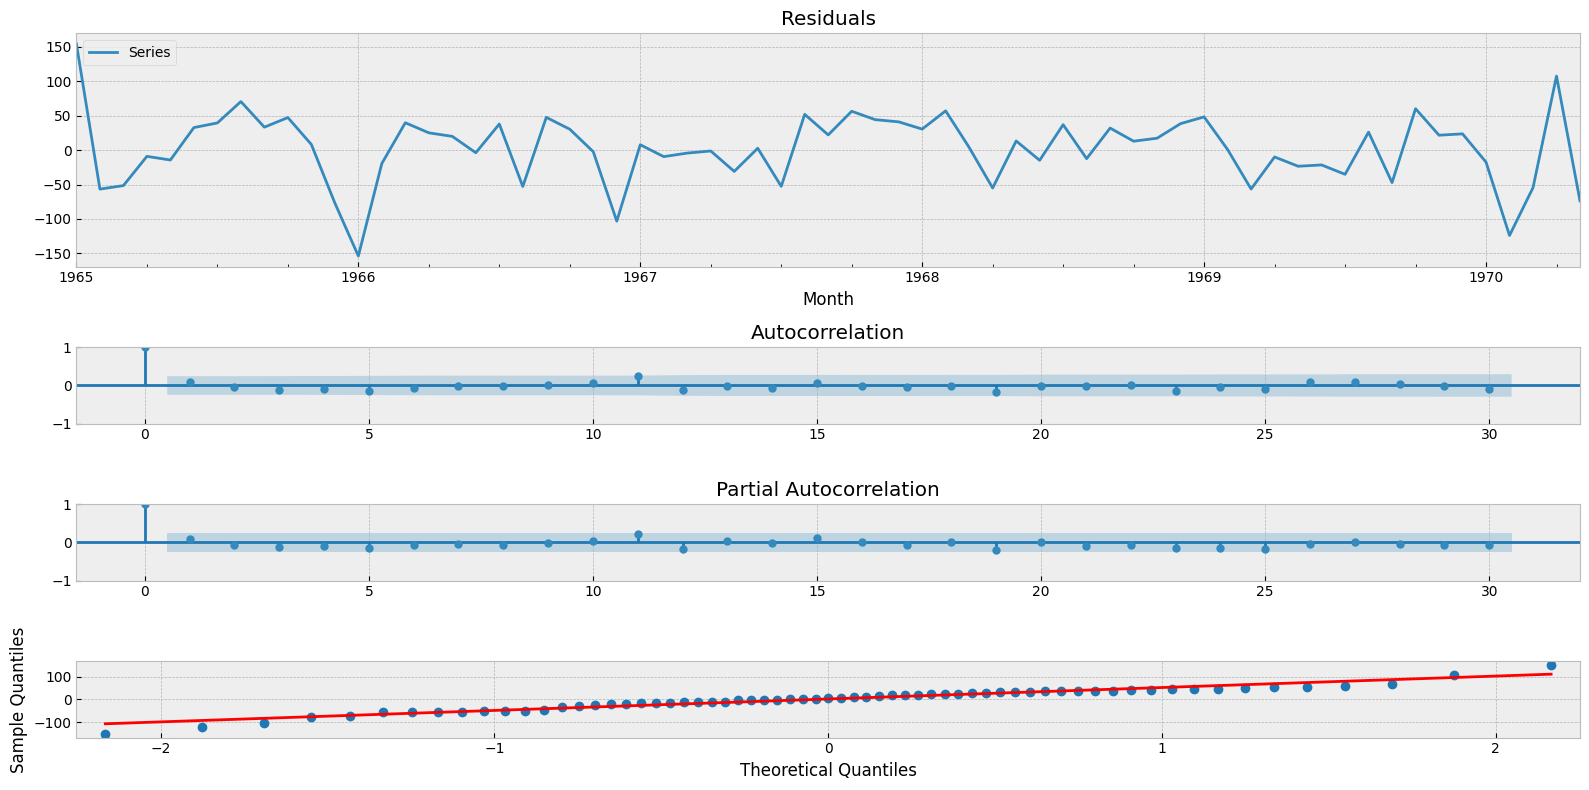

In [11]:
resid = (train - best_model.fittedvalues).dropna()

tsplot(resid, "Residuals", lags=30)

# Предсказание ряда с помощью классического ML + экспериментирование с фичами ряда (лагами).

Преобразуем временной ряд в табличный формат,  
добавив лаги, скользящие характеристики и календарные признаки.

Далее сравним несколько моделей:
- Ridge (линейная регрессия с L2-регуляризацией)
- RandomForestRegressor
- HistGradientBoostingRegressor


In [12]:
def make_features(y: pd.Series, lags=12):
    df = pd.DataFrame({"y": y})
    for lag in range(1, lags+1):
        df[f"lag_{lag}"] = df["y"].shift(lag)

    # rolling features
    df["roll_mean_3"]  = df["y"].shift(1).rolling(3).mean()
    df["roll_mean_12"] = df["y"].shift(1).rolling(12).mean()
    df["roll_std_12"]  = df["y"].shift(1).rolling(12).std()

    # calendar features
    df["month"] = df.index.month
    df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
    df["month_cos"] = np.cos(2*np.pi*df["month"]/12)
    df = df.drop(columns=["month"])

    df = df.dropna()
    X = df.drop(columns=["y"])
    y_target = df["y"]
    return X, y_target

X, y_target = make_features(y, lags=12)

X_train, y_train = X.iloc[:-test_size], y_target.iloc[:-test_size]
X_test,  y_test  = X.iloc[-test_size:], y_target.iloc[-test_size:]

In [13]:
models = {
    "Ridge": Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=1.0))]),
    "RandomForest": RandomForestRegressor(n_estimators=500, random_state=42),
    "HistGB": HistGradientBoostingRegressor(random_state=42)
}

def cv_score(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for train_idx, val_idx in tscv.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        m = model
        m.fit(X_tr, y_tr)
        pred = m.predict(X_val)
        rmses.append(rmse(y_val, pred))
    return float(np.mean(rmses)), float(np.std(rmses))

cv_results = []
for name, model in models.items():
    mean_rmse, std_rmse = cv_score(model, X_train, y_train, n_splits=5)
    cv_results.append([name, mean_rmse, std_rmse])

cv_df = pd.DataFrame(cv_results, columns=["Model", "CV_RMSE_mean", "CV_RMSE_std"]).sort_values("CV_RMSE_mean")
cv_df

,Model,CV_RMSE_mean,CV_RMSE_std
1,RandomForest,84.237506,36.117540
0,Ridge,85.227939,45.910053
2,HistGB,156.546627,57.979404


In [14]:
# Возьмем лучшую модель по CV, обучим на train, проверим на test
best_ml_name = cv_df.iloc[0]["Model"]
best_ml = models[best_ml_name]

best_ml.fit(X_train, y_train)
pred_test = best_ml.predict(X_test)

ml_rmse = rmse(y_test, pred_test)
best_ml_name, ml_rmse

('RandomForest', 115.85238699885875)

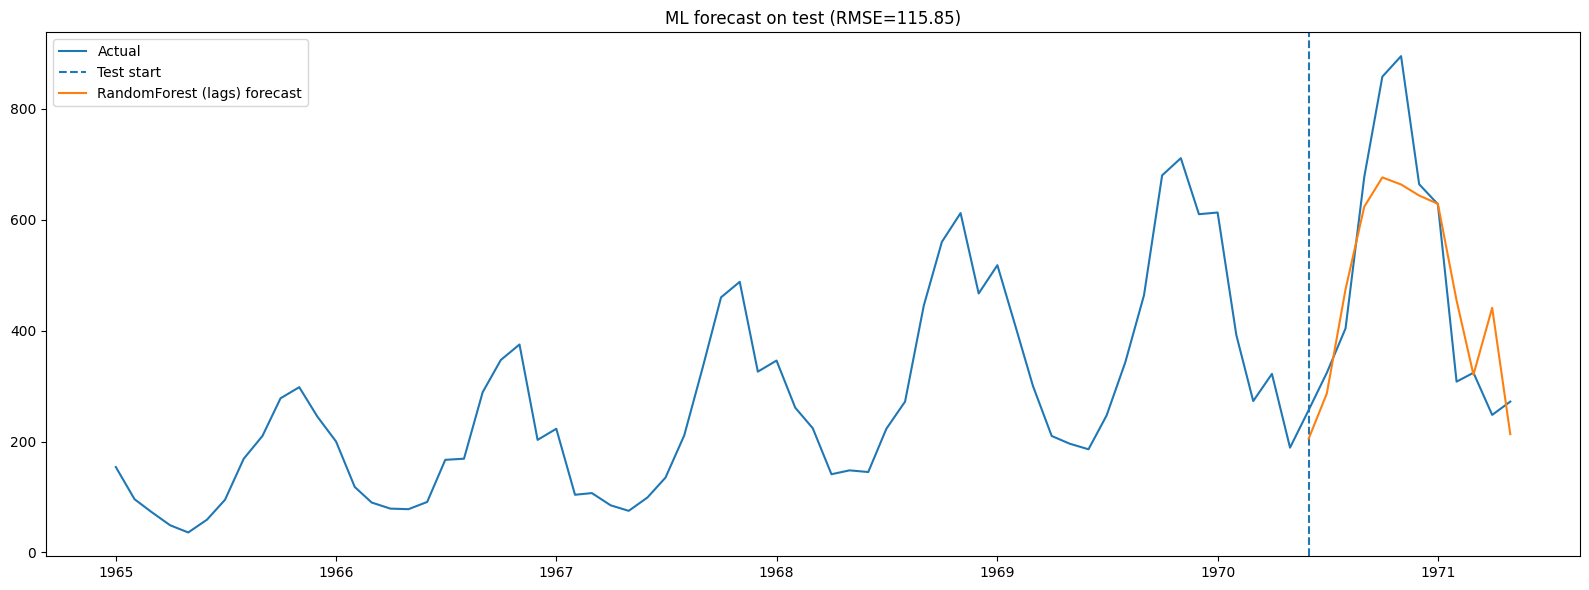

In [15]:
plt.figure(figsize=(16,6))
plt.plot(y.index, y.values, label="Actual")
plt.axvline(y_test.index[0], linestyle="--", label="Test start")

plt.plot(y_test.index, pred_test, label=f"{best_ml_name} (lags) forecast")
plt.title(f"ML forecast on test (RMSE={ml_rmse:.2f})")
plt.legend()
plt.tight_layout()
plt.show()

# Итоговое сравнение на всём временном ряду

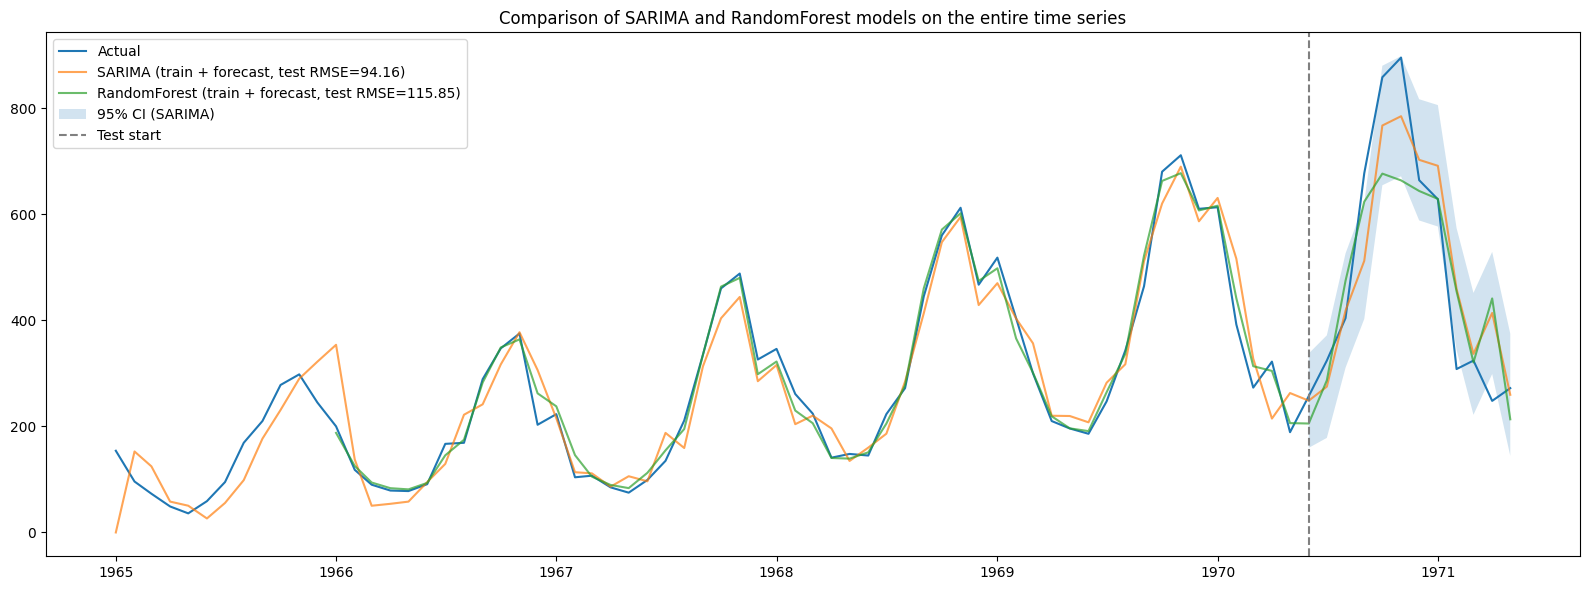

In [16]:
sarima_full = pd.concat([best_model.fittedvalues, fc])
ml_full = best_ml.predict(X)

plt.figure(figsize=(16,6))
plt.plot(y.index, y.values, label='Actual')
plt.plot(sarima_full.index, sarima_full.values, label=f'SARIMA (train + forecast, test RMSE={score:.2f})', linestyle='-', alpha=0.7)
plt.plot(X.index, ml_full, label=f'{best_ml_name} (train + forecast, test RMSE={ml_rmse:.2f})', linestyle='-', alpha=0.7)
plt.fill_between(test.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2, label="95% CI (SARIMA)")
plt.axvline(test.index[0], linestyle='--', color='gray', label='Test start')

plt.title('Comparison of SARIMA and RandomForest models on the entire time series')
plt.legend()
plt.tight_layout()
plt.show()